# Import Libraries

In [198]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

%matplotlib inline
seed = 0
np.random.seed(seed)

tf.random.set_seed(seed)

os.environ['XILINX_VITIS'] = '/tools/Xilinx/Vitis/2023.2'
os.environ['PATH'] = os.environ['XILINX_VITIS'] + '/bin:' + os.environ['PATH']

# Generate a Dataset

In [199]:
# parameters
fs     = 100e3          # ADC sampling rate (Hz)
f_sig  = 1e3            # sine frequency (Hz)
Vpk    = 1.0            # sine amplitude (V)
N      = 100_000        # number of samples

# time vector
t = np.arange(N) / fs

# ideal sine wave
y_true = Vpk * np.sin(2 * np.pi * f_sig * t)

# simulate ADC nonidealities
gain   = 1.05                       # +5% gain error
offset = 0.01                       # +10 mV offset
noise  = np.random.normal(0, .005, size=N)
X_raw  = gain*y_true + offset + noise

# now X_raw is the feature, y_true is the label

# Create Training-Test Split of Data
## 80% Training | 20% Testing

In [200]:
X = X_raw.reshape(-1, 1) #reshapse X to be a 2D array
y = y_true        

# 20% for testing, 80% for training
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scale data for NN to converge faster

In [201]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

print("Shapes:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Shapes: (80000, 1) (80000,) (20000, 1) (20000,)


## Construct the Model

In [202]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
from tensorflow.keras.layers import Activation
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu

In [203]:
model = Sequential()

# -- HIDDEN LAYER 1 --
model.add(
    QDense(
        64,
        input_shape = (1,),                  # One ADC Channel being read in (for now)
        name = 'fc1',
        kernel_quantizer = quantized_bits(20, 0, alpha=1), # ADC has a 20 bit resolution so make quantized bits 20 bits minimum 
        bias_quantizer = quantized_bits(20, 0, alpha=1),
        kernel_initializer = 'lecun_uniform',
        kernel_regularizer = l1(1e-4),
    )
)
model.add(
    QActivation(
        activation = quantized_relu(6),      # 6-bit ReLU for hidden activations
        name = 'relu1'
    )
)

# -- HIDDEN LAYER 2 --
model.add(
    QDense(
        32,
        name = 'fc2',
        kernel_quantizer = quantized_bits(20, 0, alpha=1),
        bias_quantizer = quantized_bits(20, 0, alpha=1),
        kernel_initializer = 'lecun_uniform',
        kernel_regularizer = l1(1e-4),
    )
)
model.add(
    QActivation(
        activation = quantized_relu(6),
        name = 'relu2'
    )
)

# -- HIDDEN LAYER 3 --
model.add(
    QDense(
        16,
        name = 'fc3',
        kernel_quantizer = quantized_bits(20, 0, alpha=1),
        bias_quantizer = quantized_bits(20, 0, alpha=1),
        kernel_initializer = 'lecun_uniform',
        kernel_regularizer = l1(1e-4),
    )
)
model.add(
    QActivation(
        activation = quantized_relu(6),
        name ='relu3'
    )
)

# -- OUTPUT LAYER --
model.add(
    QDense(
        1,                                 # single scalar correction
        name = 'output',
        kernel_quantizer = quantized_bits(20, 0, alpha=1),
        bias_quantizer = quantized_bits(20, 0, alpha=1),
        kernel_initializer ='lecun_uniform',
        kernel_regularizer = l1(1e-4),
    )
)
model.add(
    Activation(
        activation = 'linear',               # regression
        name = 'linear'
    )
)

In [204]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 64)                128       
                                                                 
 relu1 (QActivation)         (None, 64)                0         
                                                                 
 fc2 (QDense)                (None, 32)                2080      
                                                                 
 relu2 (QActivation)         (None, 32)                0         
                                                                 
 fc3 (QDense)                (None, 16)                528       
                                                                 
 relu3 (QActivation)         (None, 16)                0         
                                                                 
 output (QDense)             (None, 1)               

## Train with Sparsity

In [205]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

## Train the model

In [206]:
from tensorflow.keras.optimizers import Adam
from tensorflow_model_optimization.sparsity.keras import (
    UpdatePruningStep,
    PruningSummaries,
    strip_pruning
)

train = True
if train:
    # 1) Regression optimizer
    optimizer = Adam(learning_rate=1e-4)

    # 2) Compile for regression
    model.compile(
        optimizer=optimizer,
        loss='mse',       
        metrics=['mae']   
    )

    # 3) Build your standard callbacks
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=1e-6,
        lr_cooldown=2,
        lr_minimum=1e-7,
        outputDir='model_1',
    )

    # ──> **Insert pruning callbacks** so masks actually get updated every step
    callbacks.callbacks.append(UpdatePruningStep())
    callbacks.callbacks.append(PruningSummaries(log_dir='model_1/pruning_summaries'))

    # 4) Fit with pruning enabled
    history = model.fit(
        X_train_val, 
        y_train_val,
        batch_size=256,
        epochs=50,
        validation_split=0.2,
        shuffle=True,
        callbacks=callbacks.callbacks
    )

    # ──> **Strip out** the pruning wrappers before saving or exporting
    model = strip_pruning(model)
    model.save('model_1/KERAS_check_best_model.h5')

else:
    from tensorflow.keras.models import load_model
    model = load_model('model_1/KERAS_check_best_model.h5')


Epoch 1/50
  1/250 [..............................] - ETA: 5:30 - loss: 0.3456 - mae: 0.4871WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0015s vs `on_train_batch_end` time: 0.0114s). Check your callbacks.


231/250 [==========================>...] - ETA: 0s - loss: 0.1189 - mae: 0.2139
***callbacks***
saving losses to model_1/losses.log

Epoch 1: val_loss improved from inf to 0.05518, saving model to model_1/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.05518, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_1/KERAS_check_model_last.h5

Epoch 1: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

250/250 [==============================] - 2s 4ms/step - loss: 0.1142 - mae: 0.2058 - val_loss: 0.0552 - val_mae: 0.1046 - lr: 1.0000e-04
Epoch 2/50
247/250 [============================>.] - ETA: 0s - loss: 0.0410 - mae: 0.0711
***callbacks***
saving losses to model_1/losses.log

Epoch 2: val_loss improved from 0.05518 to 0.03284, saving model to model_1/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 0.05518 to 0.03284, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 2: saving 

## Output Metrics

In [207]:
y_pred = model.predict(X_test).flatten()
y_true = y_test
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_true, y_pred)

print(f"MAE : {mae:.6f} V")
print(f"RMSE: {rmse:.6f} V")
print(f"R²  : {r2:.4f}")


625/625 [==============================] - 1s 550us/step
MAE : 0.006568 V
RMSE: 0.008624 V
R²  : 0.9999


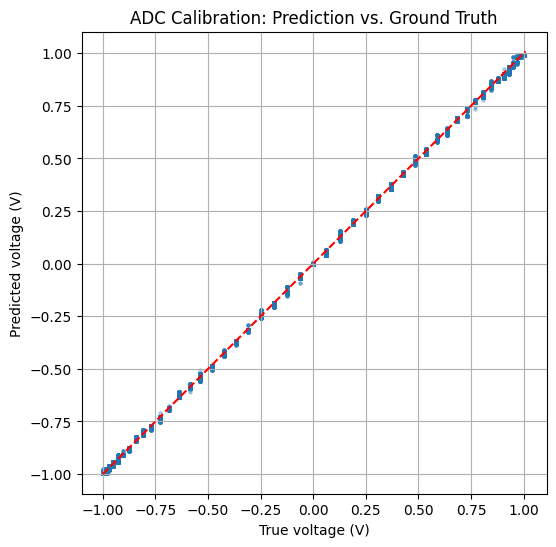

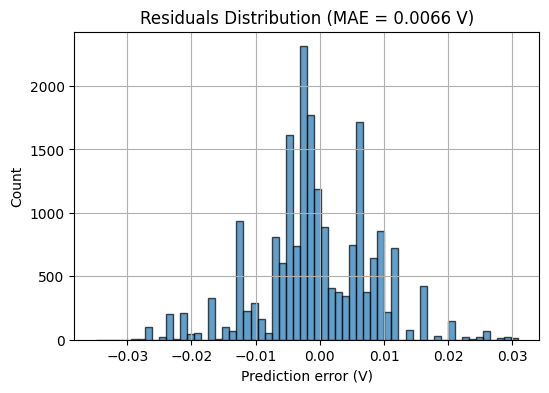

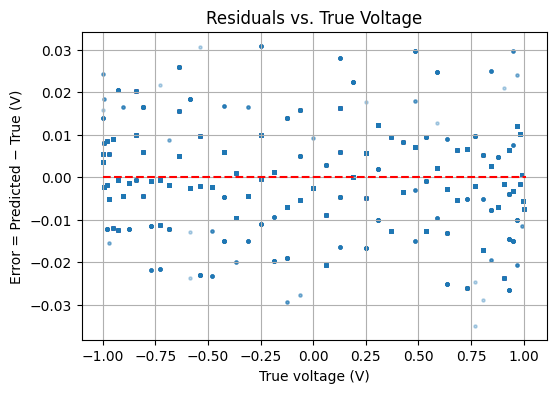

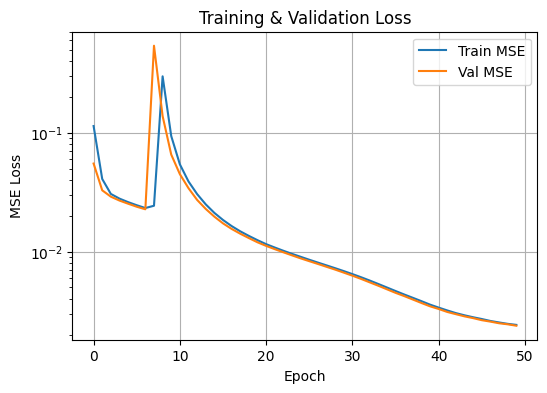

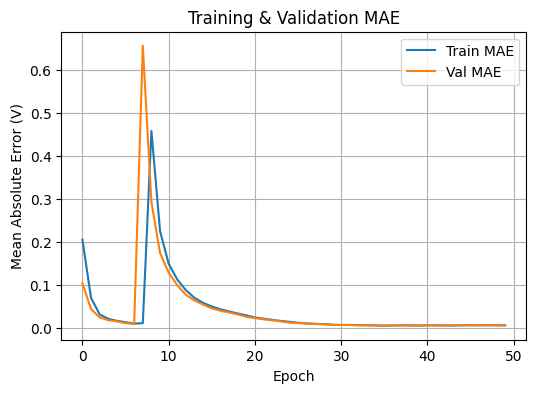

In [208]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Compute predictions if not already done
try:
    y_pred
except NameError:
    y_pred = model.predict(X_test).flatten()

# 2) Scatter: predicted vs true
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, s=5, alpha=0.3)
#lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("True voltage (V)")
plt.ylabel("Predicted voltage (V)")
plt.title("ADC Calibration: Prediction vs. Ground Truth")
plt.axis('equal')   # same scale on both axes

plt.grid(True)
plt.show()

# 3) Histogram of residuals
residuals = y_pred - y_test
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=60, edgecolor='k', alpha=0.7)
plt.xlabel("Prediction error (V)")
plt.ylabel("Count")
plt.title(f"Residuals Distribution (MAE = {np.mean(np.abs(residuals)):.4f} V)")
plt.grid(True)
plt.show()

# 4) Residual vs. true value
plt.figure(figsize=(6, 4))
plt.scatter(y_test, residuals, s=5, alpha=0.3)
plt.hlines(0, lims[0], lims[1], colors='r', linestyles='--')
plt.xlabel("True voltage (V)")
plt.ylabel("Error = Predicted − True (V)")
plt.title("Residuals vs. True Voltage")
plt.grid(True)
plt.show()

# 5) Training curves (if history available)
if 'history' in globals() and hasattr(history, 'history'):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['loss'], label='Train MSE')
    plt.plot(history.history['val_loss'], label='Val MSE')
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training & Validation Loss")
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Error (V)")
    plt.title("Training & Validation MAE")
    plt.legend()
    plt.grid(True)
    plt.show()


## Load Model

In [209]:
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
import os

os.environ['XILINX_VIVADO'] = '/tools/Xilinx/Vivado/2019.2'
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

model = load_model('model_1/KERAS_check_best_model.h5', custom_objects=co)

## Convert to hls4ml

In [210]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='name')

for layer in ['fc1', 'fc2', 'fc3', 'output']:
    config['LayerName'][layer]['ReuseFactor'] = 64
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_1/hls4ml_prj_pynq', backend='VivadoAccelerator', board='pynq-z2'
)
hls_model.compile()

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: fc1, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 16]
Layer name: relu3, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: output, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 1]
Layer name: linear, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
-----------------------------------
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Laten

/home/diag/anaconda3/envs/hls4ml-tf2/lib/python3.9/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Done


In [211]:
plotting.print_dict(hls4ml.backends.get_backend('VivadoAccelerator').create_initial_config())

Part:                xcvu13p-flga2577-2-e
ClockPeriod:         5
IOType:              io_parallel
HLSConfig
AcceleratorConfig
  Board:             pynq-z2
  Interface:         axi_stream
  Driver:            python
  Precision
    Input:           float
    Output:          float


## CPU Simulation of hls4ml NN

In [213]:
hls_model.compile()

X_test_c = np.ascontiguousarray(X_test)

# Run the HLS model in CPU (C-simulation) mode
y_hls = hls_model.predict(X_test_c)

# Save the HLS outputs for later comparison
np.save('model_1/y_hls.npy', y_hls)

Writing HLS project


Done


## Synthesize & Make Bitfile

In [214]:
hls_model.build(csim=False, synth=True, export=True, bitfile=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'diag' on host 'WPS-175354' (Linux_x86_64 version 6.8.0-59-generic) on Mon Jun 16 11:48:25 EDT 2025
INFO: [HLS 200-10] On os Ubuntu 22.04.5 LTS
INFO: [HLS 200-10] In directory '/home/diag/Downloads/model_1/hls4ml_prj_pynq'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/diag/Downloads/model_1/hls4ml_prj_pynq/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject_axi.cpp' to the project
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10] Ad

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.816',
  'BestLatency': '86',
  'WorstLatency': '86',
  'IntervalMin': '69',
  'IntervalMax': '69',
  'DSP': '17',
  'FF': '7346',
  'LUT': '13161',
  'BRAM_18K': '0',
  'URAM': '0',
  'AvailableBRAM_18K': '280',
  'AvailableDSP': '220',
  'AvailableFF': '106400',
  'AvailableLUT': '53200',
  'AvailableURAM': '0'},
 'TimingReport': {'WNS': 0.368,
  'TNS': 0.0,
  'WHS': 0.021,
  'THS': 0.0,
  'WPWS': 3.75,
  'TPWS': 0.0}}

## Final Resource Usage

In [215]:
!sed -n '30,45p' model_1/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper_utilization_placed.rpt


+----------------------------+------+-------+-----------+-------+
|          Site Type         | Used | Fixed | Available | Util% |
+----------------------------+------+-------+-----------+-------+
| Slice LUTs                 | 6354 |     0 |     53200 | 11.94 |
|   LUT as Logic             | 6114 |     0 |     53200 | 11.49 |
|   LUT as Memory            |  240 |     0 |     17400 |  1.38 |
|     LUT as Distributed RAM |   22 |     0 |           |       |
|     LUT as Shift Register  |  218 |     0 |           |       |
| Slice Registers            | 7498 |     0 |    106400 |  7.05 |
|   Register as Flip Flop    | 7498 |     0 |    106400 |  7.05 |
|   Register as Latch        |    0 |     0 |    106400 |  0.00 |
| F7 Muxes                   |   31 |     0 |     26600 |  0.12 |
| F8 Muxes                   |    0 |     0 |     13300 |  0.00 |
+----------------------------+------+-------+-----------+-------+



## Run these commands in shell from your file directory

### make directory for project

mkdir -p model_1/hls4ml_prj_pynq/package

### Copy the .bit
cp \
  model_1/hls4ml_prj_pynq/myproject_vivado_accelerator/\
project_1.runs/impl_1/design_1_wrapper.bit \
  model_1/hls4ml_prj_pynq/package/hls4ml_nn.bit

### Copy the .hwh
cp \
  model_1/hls4ml_prj_pynq/myproject_vivado_accelerator/\
project_1.srcs/sources_1/bd/design_1/hw_handoff/design_1.hwh \
  model_1/hls4ml_prj_pynq/package/hls4ml_nn.hwh

### Copy the driver
cp \
  model_1/hls4ml_prj_pynq/axi_stream_driver.py \
  model_1/hls4ml_prj_pynq/package/


### Finally, archive
tar -czvf model_1/hls4ml_prj_pynq/package.tar.gz \
  -C model_1/hls4ml_prj_pynq/package/ .

# Deployment Section

In [222]:
from axi_stream_driver import NeuralNetworkOverlay

nn = NeuralNetworkOverlay('hls4ml_nn.bit', X_test.shape, y_test.shape)

ModuleNotFoundError: No module named 'axi_stream_driver'

In [ ]:
y_hw, latency, throughput = nn.predict(X_test, profile=True)

In [ ]:
np.save('y_hw.npy', y_hw)